In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from matplotlib import pyplot as plt
import os
import json

plt.style.use('seaborn-deep')

Read the data. You can either choose to look at the full training set, which may give an inflated sparation power, of the validation set, which will have fewer statistics.

In [2]:
full_df = pd.read_pickle('/data/newhouse/LRT/batch/master/training/tracks_weighted.pkl')
full_df

,numberOfPixelHoles,numberOfSCTHoles,numberOfSCTDoubleHoles,numberOfContribPixelLayers,numberOfBLayerHits,numberOfGangedFlaggedFakes,numberOfPixelHits,numberOfSCTHits,standardDeviationOfChi2OS,track_pt,...,truthProbability,truthBarcode,signal,geometric_var,abs_z0,abs_d0,abs_eta,Sihits,is_good,weights
2436564,0.0,0.0,0.0,3.0,-1.0,0.0,3.0,8.0,139.0,2791.836456,...,1.000000,2459,RPVLF,1.286456,52.148543,5.186578,0.186277,11.0,True,1
2095452,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,8.0,97.0,1491.453122,...,0.800000,200174,HNL,0.202004,19.248379,13.718926,0.831585,9.0,True,1
2662575,0.0,0.0,0.0,1.0,-1.0,0.0,2.0,8.0,69.0,1183.624512,...,1.000000,200040,HNL,0.585028,172.962090,43.974552,0.814237,10.0,True,1
2100967,1.0,0.0,0.0,1.0,-1.0,0.0,1.0,10.0,99.0,1285.761653,...,0.833333,200102,HNL,1.776335,11.981685,24.358263,2.067754,11.0,True,1
2534252,0.0,0.0,0.0,3.0,-1.0,0.0,3.0,9.0,97.0,1538.661897,...,0.933333,2001133,HNL,0.339448,37.727240,5.855665,1.378940,12.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347462,0.0,1.0,0.0,1.0,-1.0,0.0,1.0,8.0,129.0,1806.987160,...,1.000000,0,HNL,0.373010,120.408718,15.788794,1.358097,9.0,False,1
285675,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,7.0,48.0,1146.266562,...,1.000000,0,VH4b,0.089769,311.817440,60.555431,1.953836,8.0,False,1
1452710,0.0,1.0,0.0,1.0,-1.0,0.0,1.0,7.0,131.0,1821.200646,...,0.555556,0,HNL,0.043599,99.811858,30.255880,2.071283,8.0,False,1
845497,1.0,1.0,0.0,3.0,-1.0,0.0,3.0,8.0,212.0,1224.761120,...,0.571429,0,RPVLF,2.966626,418.289387,5.668040,2.514737,11.0,False,1


In [3]:
# load the model
from keras.models import model_from_json
with open('/home/newhouse/tmp/model/20200715_060616/architecture.json', 'r') as file:
    model = model_from_json(file.read())
    print('done')
print(model.summary())

# Load the weights
model.load_weights('/home/newhouse/tmp/model/20200715_060616/weights.h5')
print('done')

done
Model: "r3lrt_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 8)]               0         
_________________________________________________________________
dense_0 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
regularizer_1 (Dense)        (None, 64)                1600      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 1)            

In [4]:
import json
with open('/home/newhouse/tmp/model/20200715_060616/variables.json', 'r') as file:
#     print(file.read())
    variables_dict = json.loads(file.read())


In [5]:
input_variables = [var['name'] for var in variables_dict['inputs'][0]['variables']]
# print(input_variables)

In [6]:
# Manually shift and scale the inputs based on the variables.json
df_shifted = (full_df[input_variables] + [var['offset'] for var in variables_dict['inputs'][0]['variables']])
df_shifted_scaled = (df_shifted*[var['scale'] for var in variables_dict['inputs'][0]['variables']])
del df_shifted
# print(df_shifted_scaled.std())
# print(df_shifted_scaled.mean())


In [7]:
predictions = model.predict(df_shifted_scaled)
full_df['predictions'] = predictions
# rename for convenience
df = full_df

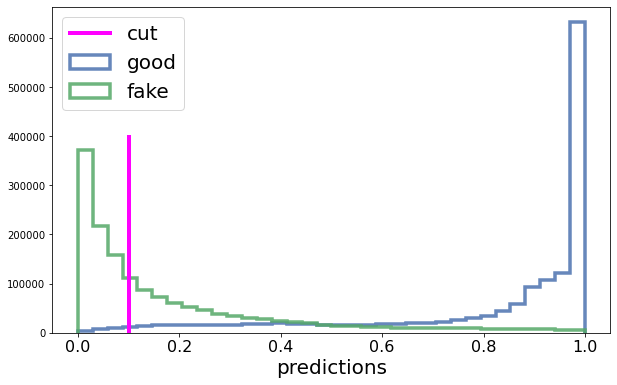

In [8]:
var = 'predictions'
stack = False

good_query = 'truthProbability >= 0.5 & linkValid == True'
fake_query = 'truthProbability < 0.5 | linkValid == False'
# Set an 'is_good' column for the full df
df['is_good'] = False
df['is_good'] = (df['truthProbability']>=0.5) & df['linkValid']
# Create slices for convenience
good = df.query(good_query)
fake = df.query(fake_query)


fig, ax = plt.subplots(1, 1,figsize=(10,6))

plot_options = {
    'histtype' : 'step',
    'linewidth' : 3.5, 
    'alpha' : 0.85, 
    'density' : None,
    'bins' : np.linspace(0,1,35),
    'log' : False
}

def plot_truth_prob(good, fake):
    fake_vals, bin_edges = np.histogram(fake[var], plot_options['bins'])
    if not stack: fake_vals = None
    good_vals = ax.hist(good[var], edgecolor='#4C72B0', label='good', bottom=fake_vals,  **plot_options)
    fake_vals = ax.hist(fake[var], edgecolor='#55A868', label='fake', **plot_options)
    ax.axvline(0.1, ymax=0.6, label='cut', linewidth=4, color='magenta')
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlabel(var, fontsize = 20)
    ax.tick_params(axis='x', which='major', labelsize=16)
    return ax

plot_truth_prob(good, fake)

In [9]:
import matplotlib
def plot2d(df, var_a, var_b, nentries=1000, bins=[10,10], title='', norm=None):
    fig = plt.figure(figsize=[15,10])
    h, xedges, yedges, image = plt.hist2d(x=df[0:nentries][var_a], y=df[0:nentries][var_b], bins=bins, norm=norm)
    plt.colorbar(image)
    ax = fig.gca()
    ax.set_xlabel(var_a, fontsize=30)
    ax.set_ylabel(var_b, fontsize=30)
    ax.set_title(title, fontsize=30)

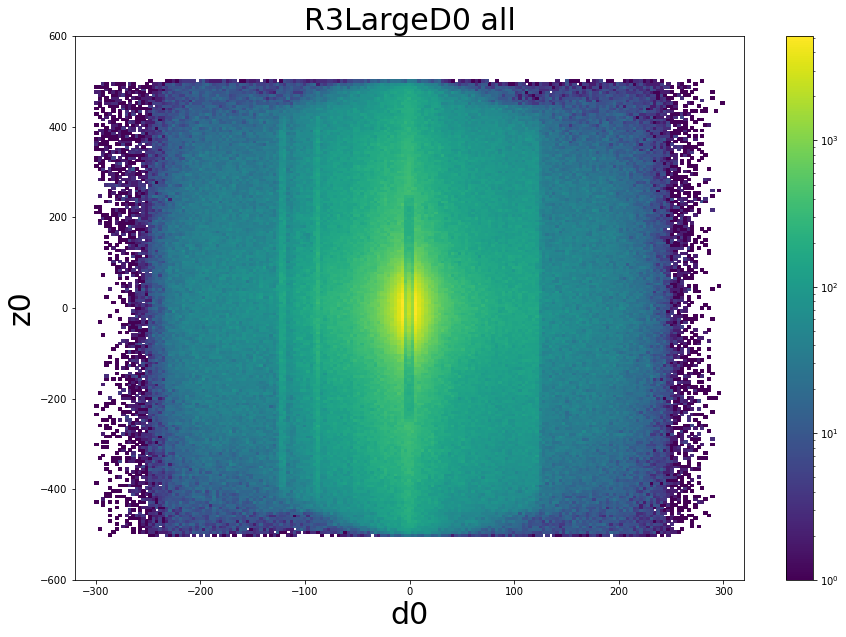

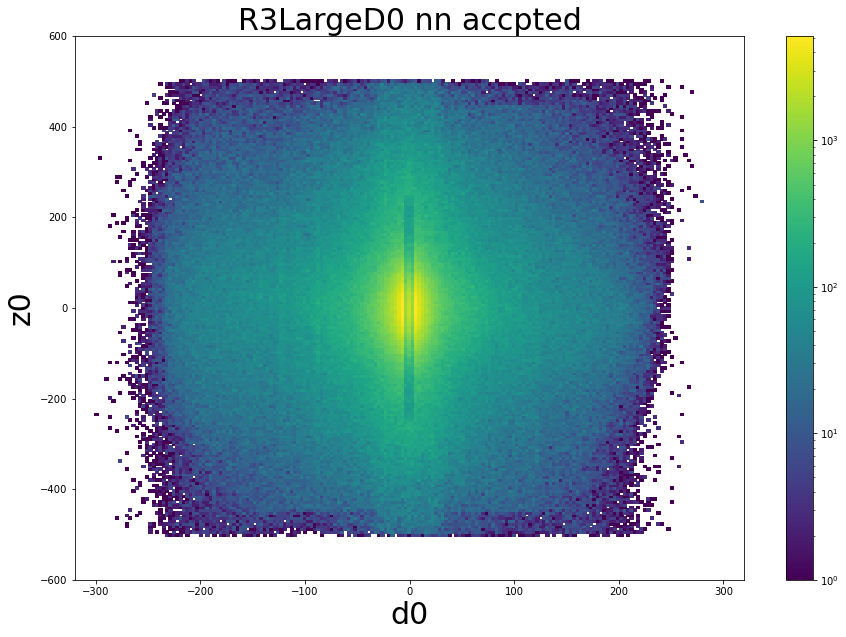

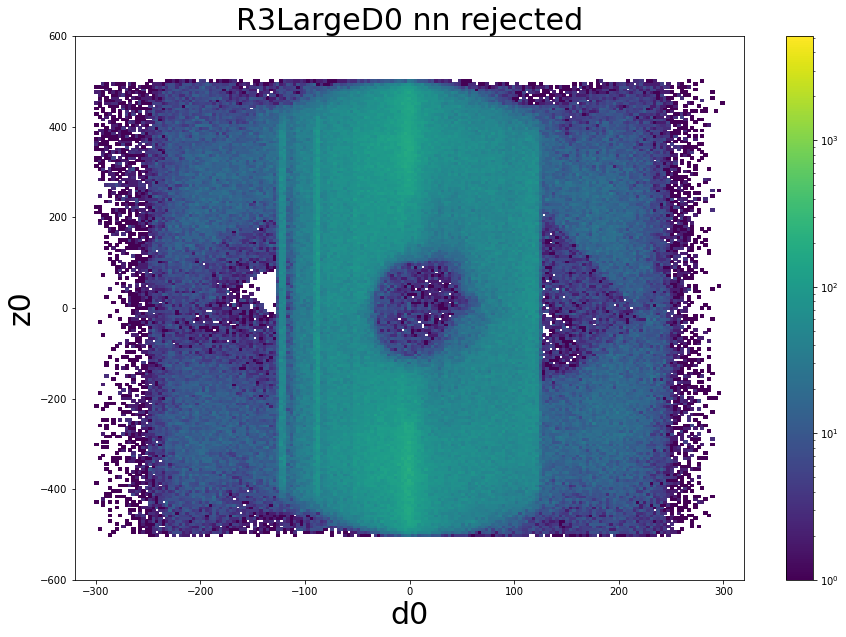

In [10]:
bins = [np.linspace(-320,320,200), np.linspace(-600,600,200)]
norm=matplotlib.colors.LogNorm()
plot2d(df, 'd0', 'z0', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'd0', 'z0', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'd0', 'z0', -1, bins, 'R3LargeD0 nn rejected', norm=norm)

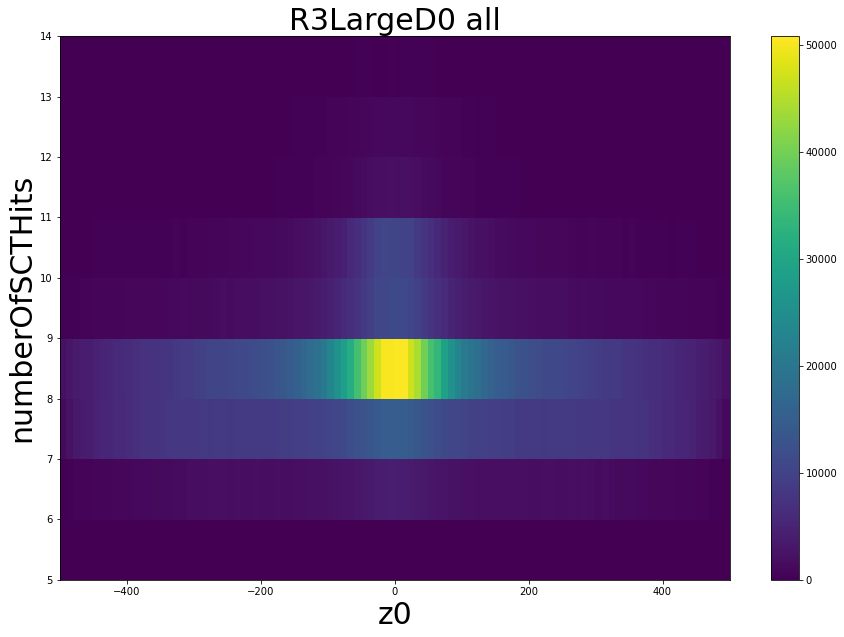

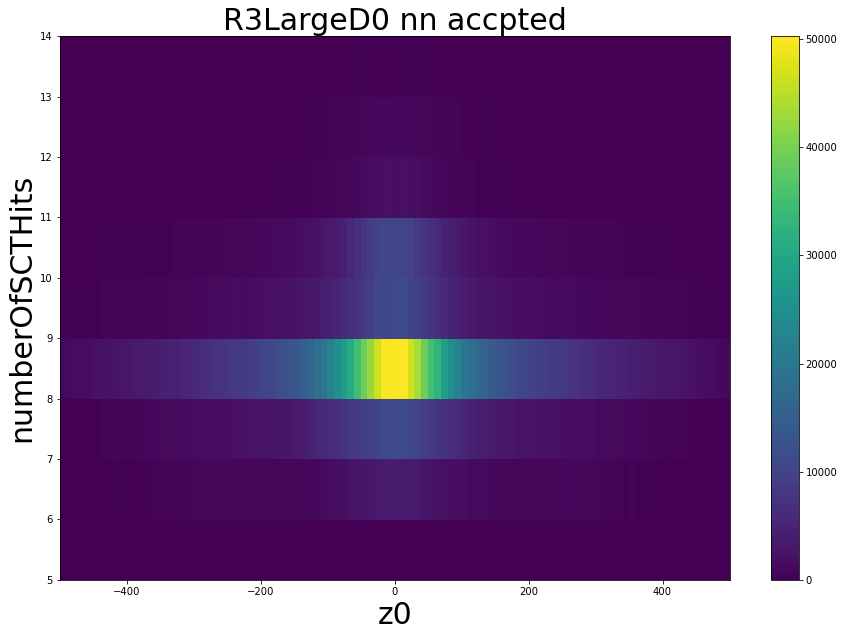

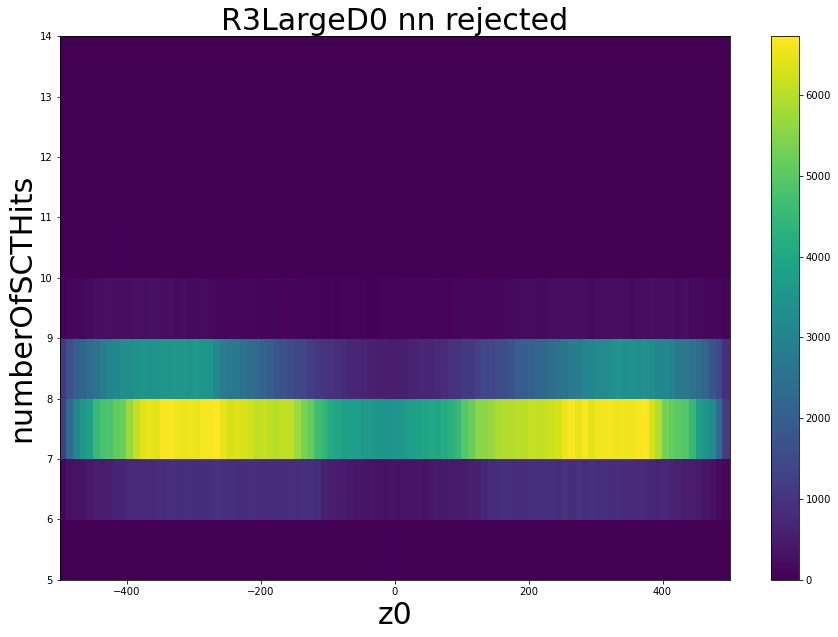

In [11]:
bins = [100, np.arange(5,15)]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'z0', 'numberOfSCTHits', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'z0', 'numberOfSCTHits', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'z0', 'numberOfSCTHits', -1, bins, 'R3LargeD0 nn rejected', norm=norm)

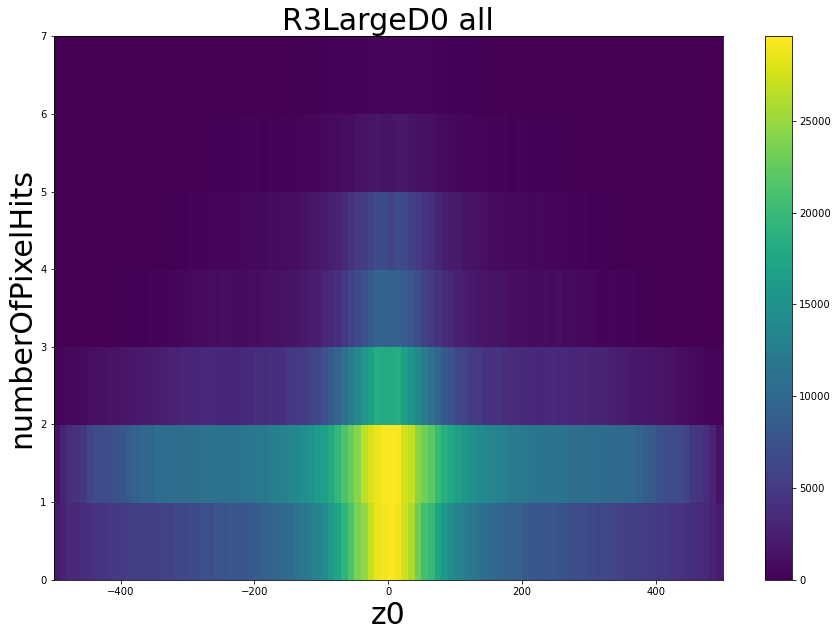

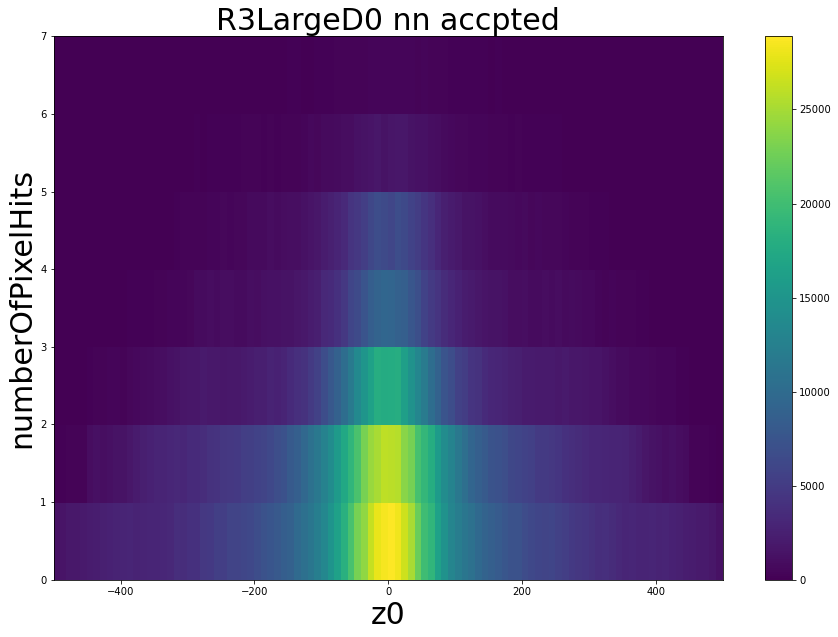

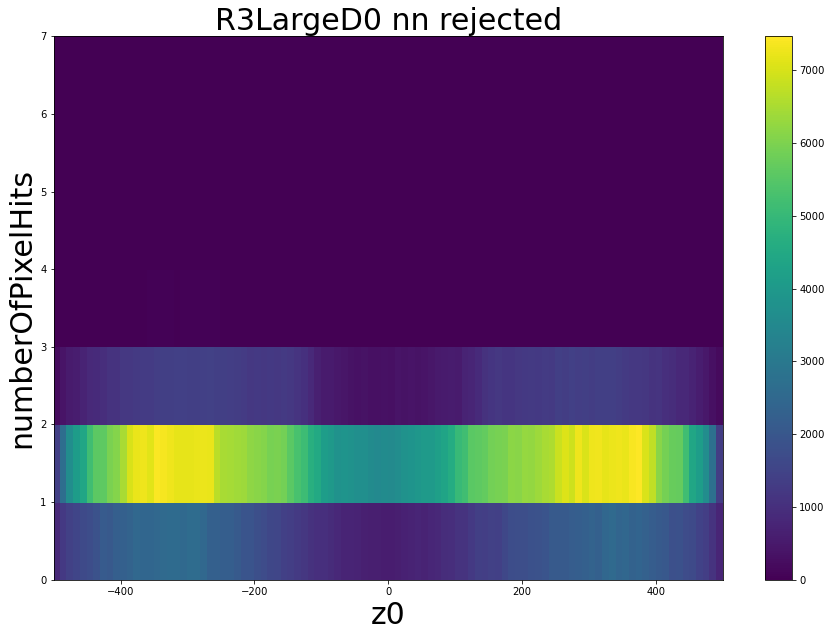

In [12]:
bins = [100, np.arange(0,8)]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'z0', 'numberOfPixelHits', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'z0', 'numberOfPixelHits', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'z0', 'numberOfPixelHits', -1, bins, 'R3LargeD0 nn rejected', norm=norm)

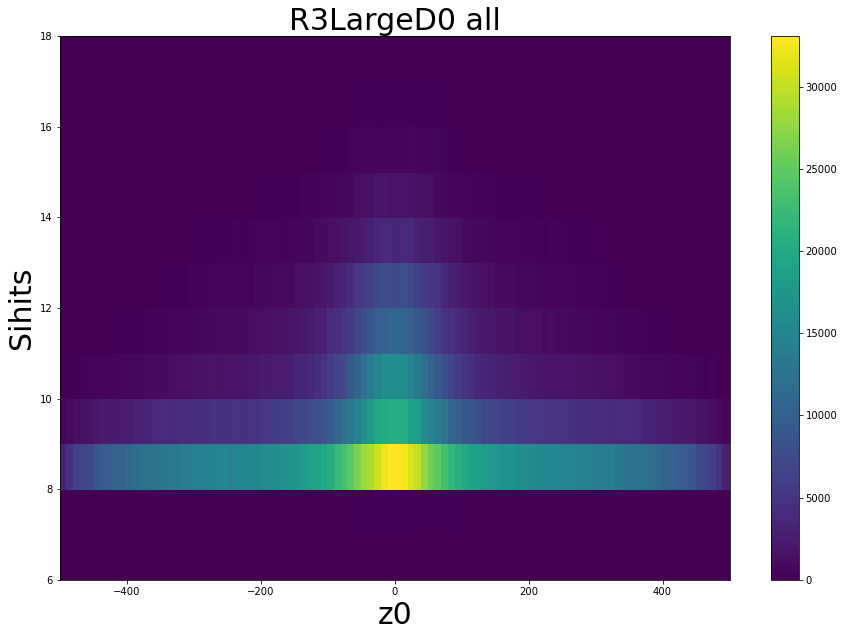

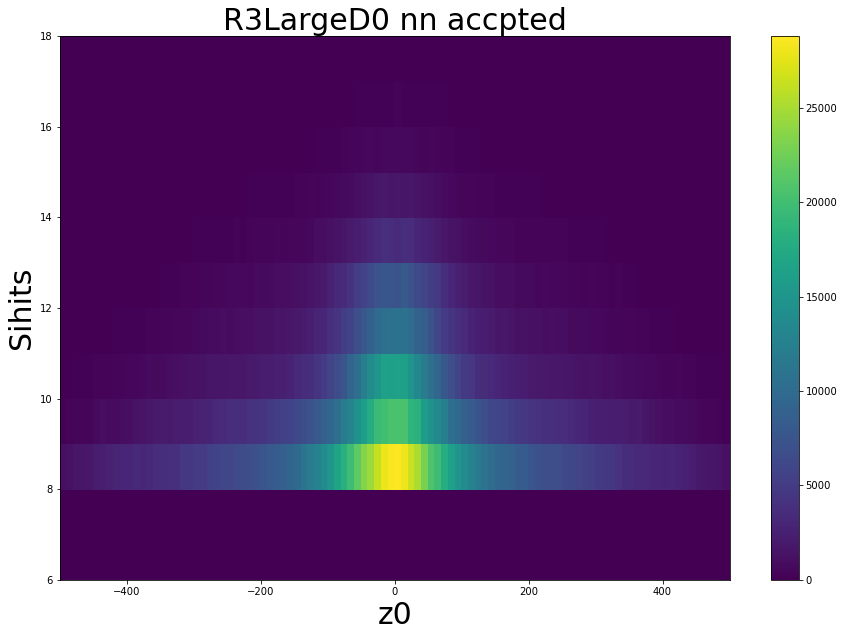

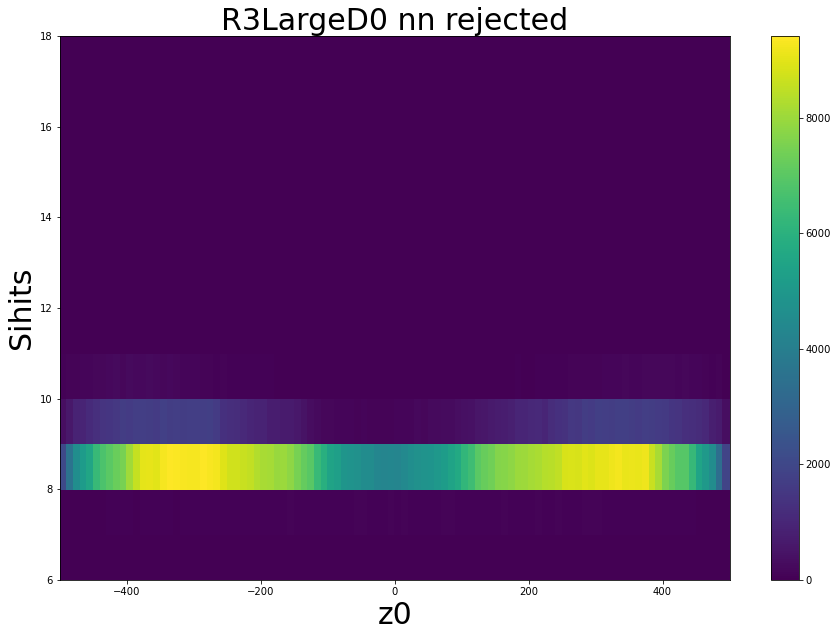

In [13]:
bins = [100, np.arange(6,19)]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'z0', 'Sihits', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'z0', 'Sihits', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'z0', 'Sihits', -1, bins, 'R3LargeD0 nn rejected', norm=norm)

## df['geometric_var'] = abs(np.arctan2(abs(df.d0),df.z0)-2*np.arctan(np.exp(-df.eta)))


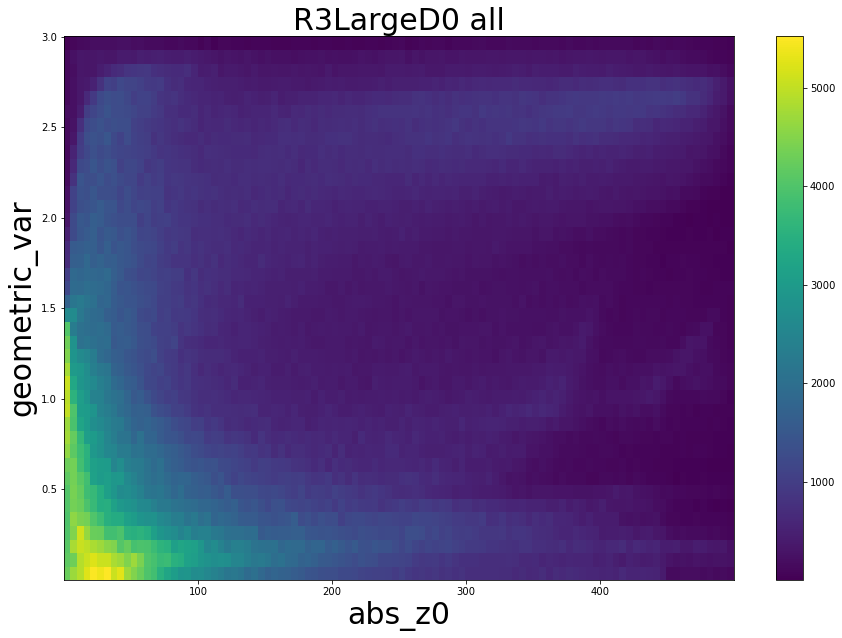

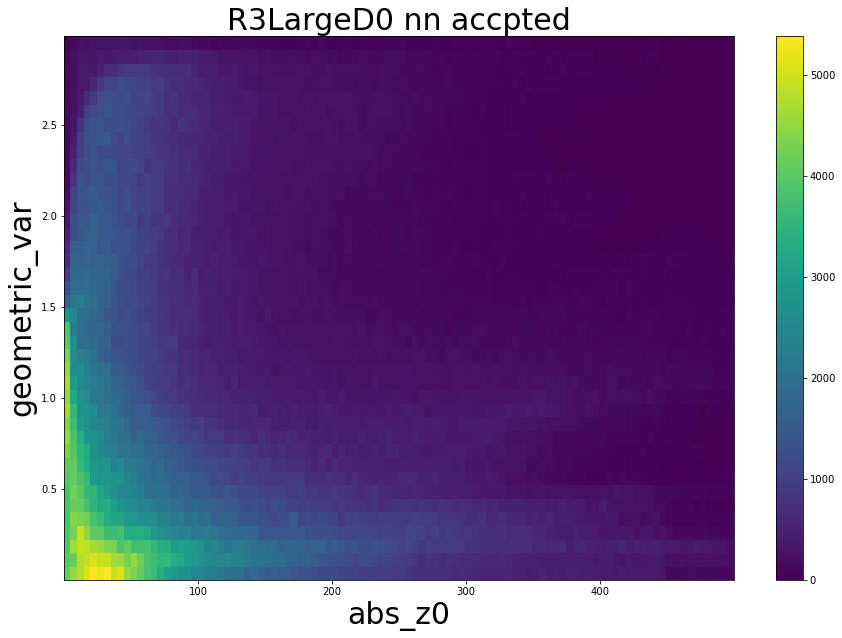

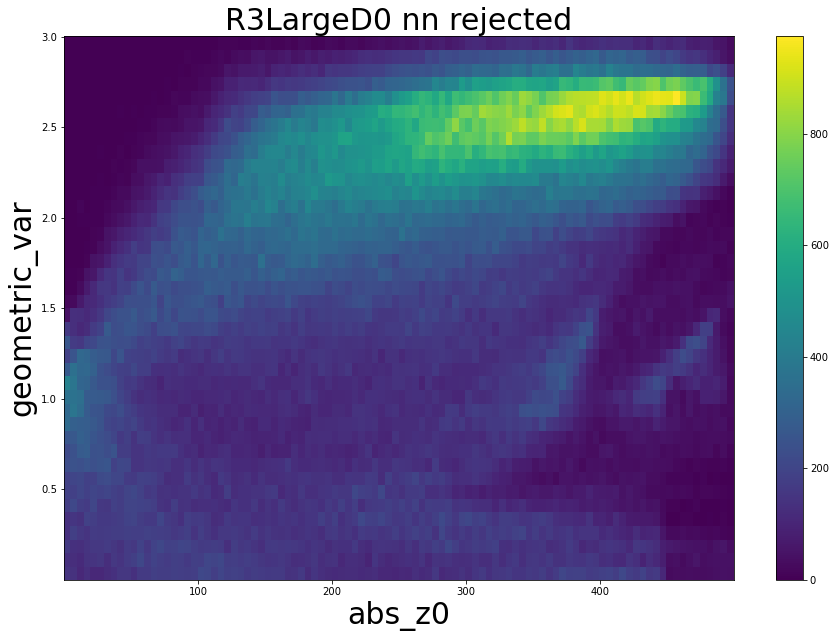

In [14]:
bins = [100, 40]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'abs_z0', 'geometric_var', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'abs_z0', 'geometric_var', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'abs_z0', 'geometric_var', -1, bins, 'R3LargeD0 nn rejected', norm=norm)

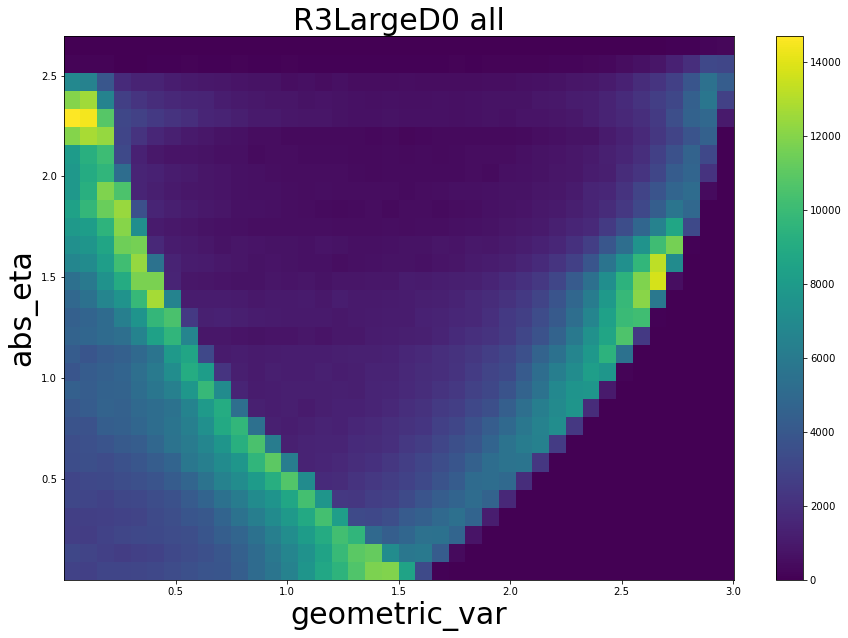

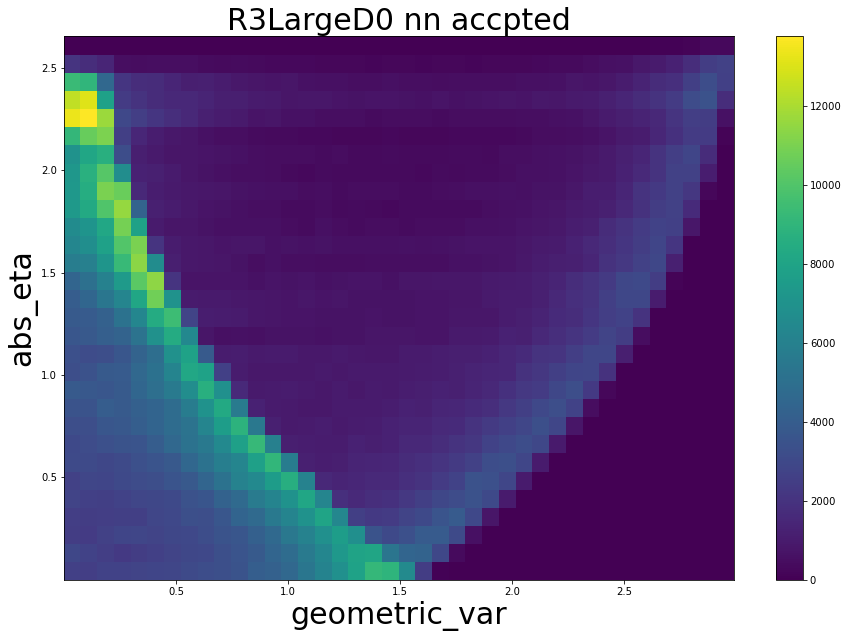

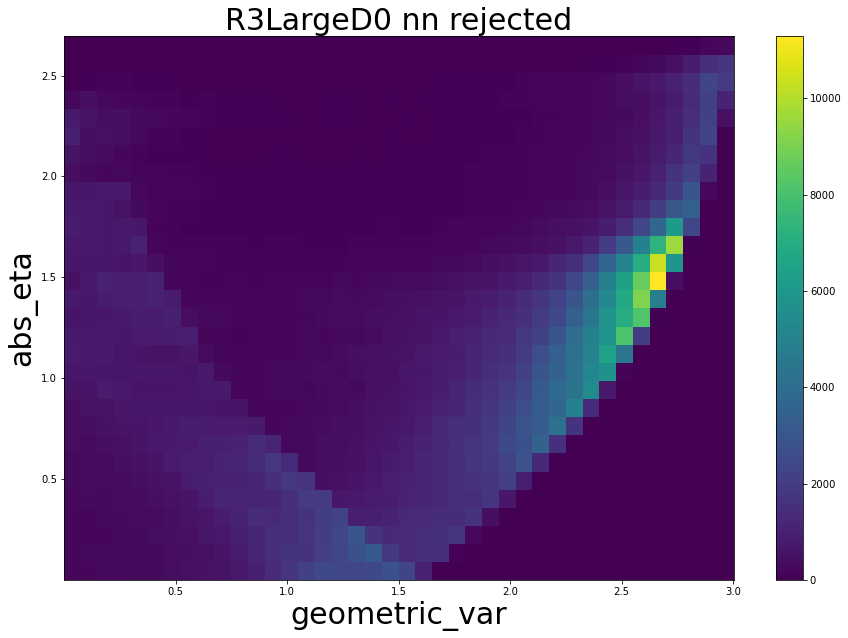

In [15]:
bins = [40, 30]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'geometric_var', 'abs_eta', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'),'geometric_var',  'abs_eta', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'geometric_var','abs_eta',  -1, bins, 'R3LargeD0 nn rejected', norm=norm)

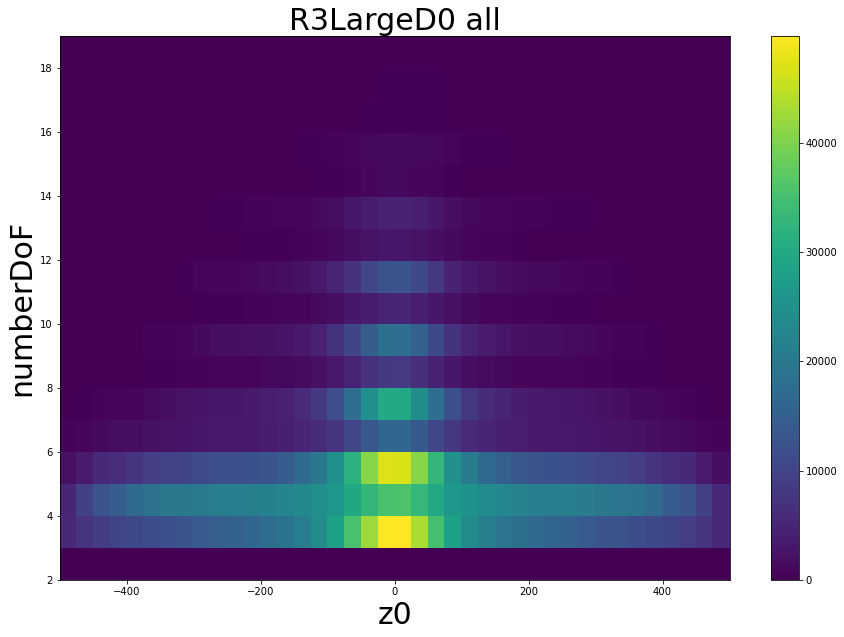

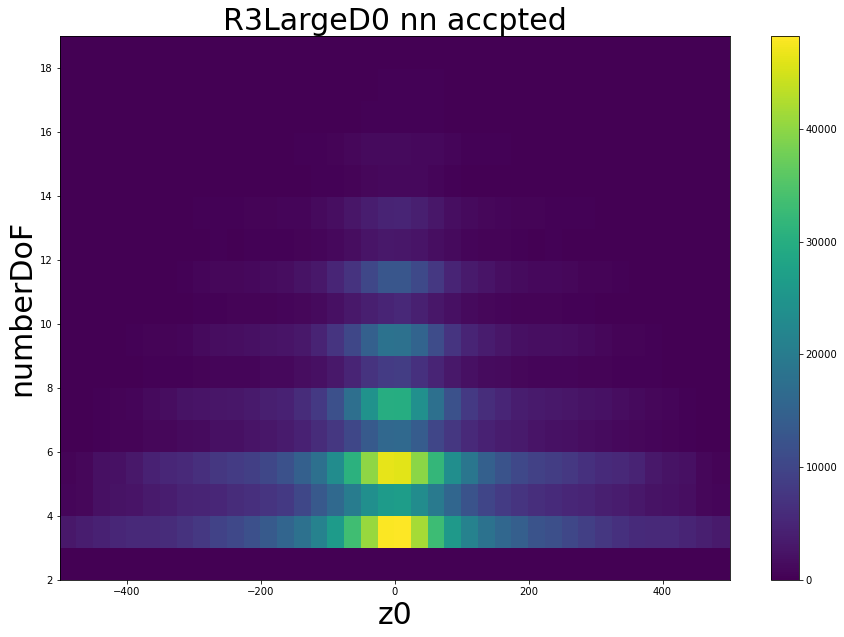

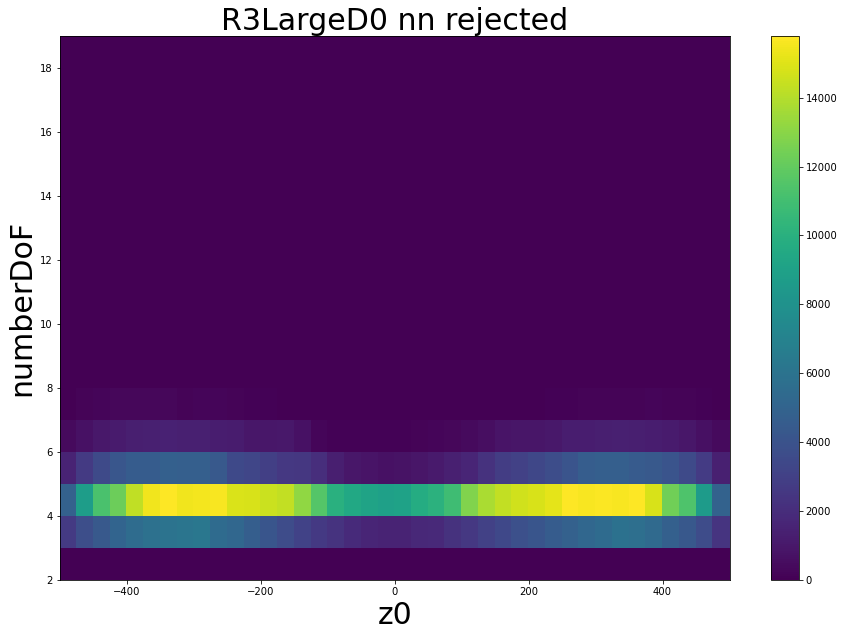

In [16]:
bins = [40, np.arange(2,20)]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'z0', 'numberDoF', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'z0', 'numberDoF', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'z0', 'numberDoF',  -1, bins, 'R3LargeD0 nn rejected', norm=norm)

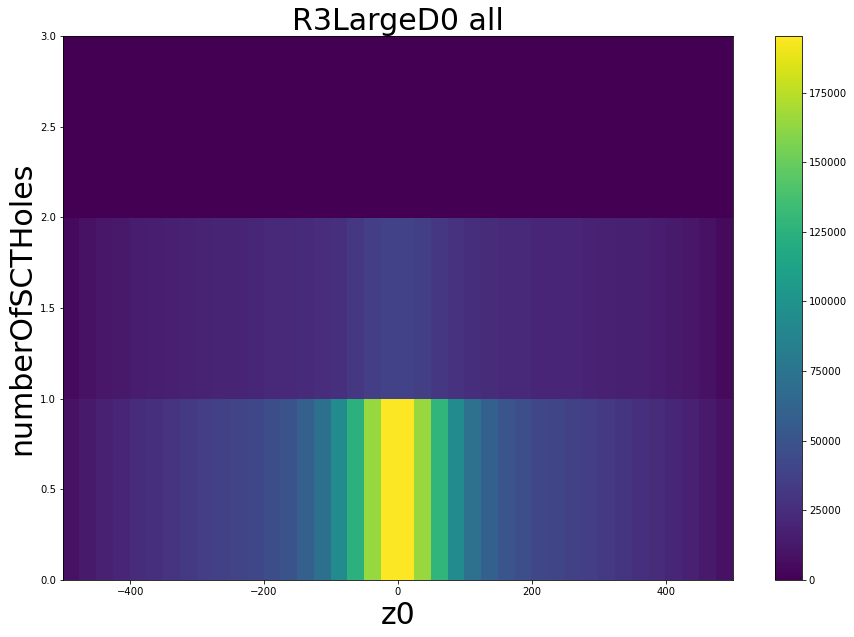

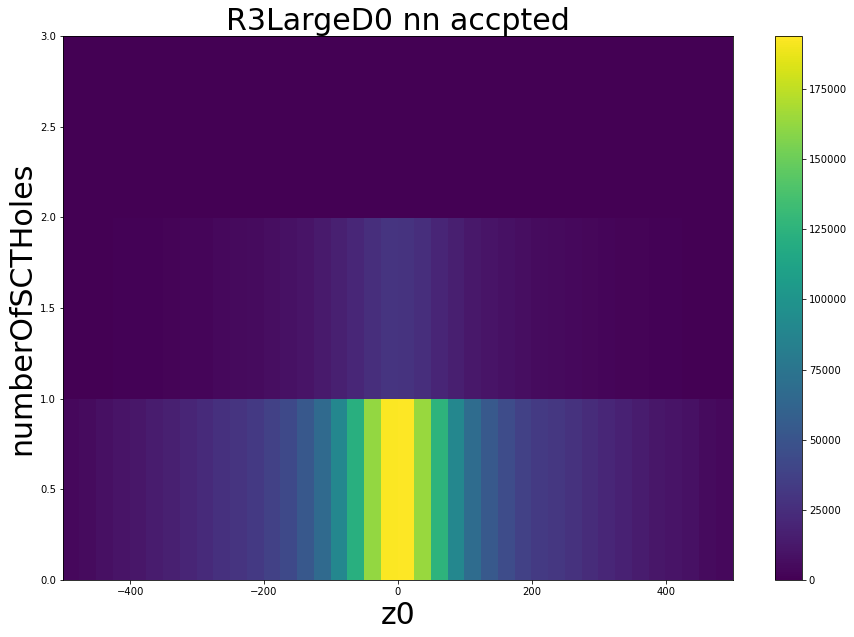

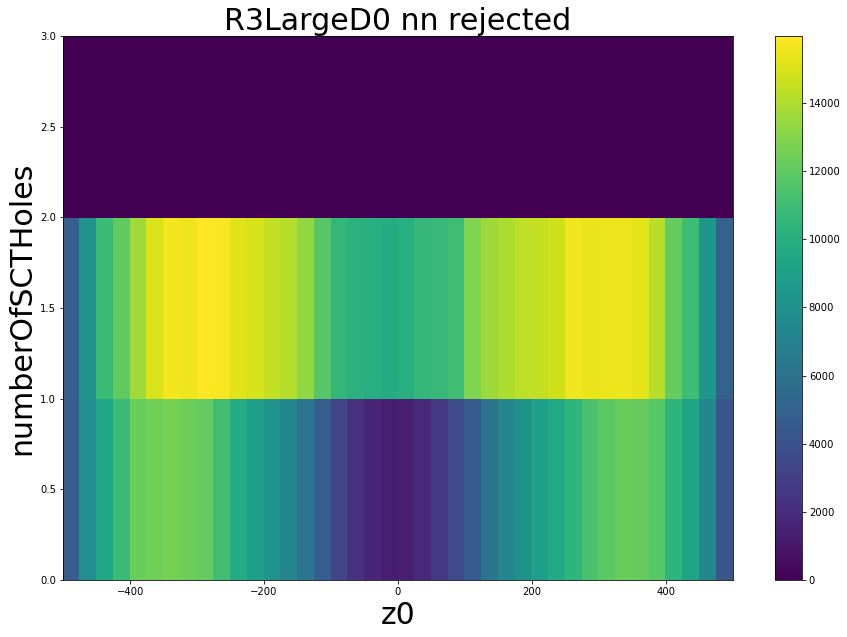

In [17]:
bins = [40, np.arange(0,4)]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'z0', 'numberOfSCTHoles', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'z0', 'numberOfSCTHoles', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'z0', 'numberOfSCTHoles',  -1, bins, 'R3LargeD0 nn rejected', norm=norm)

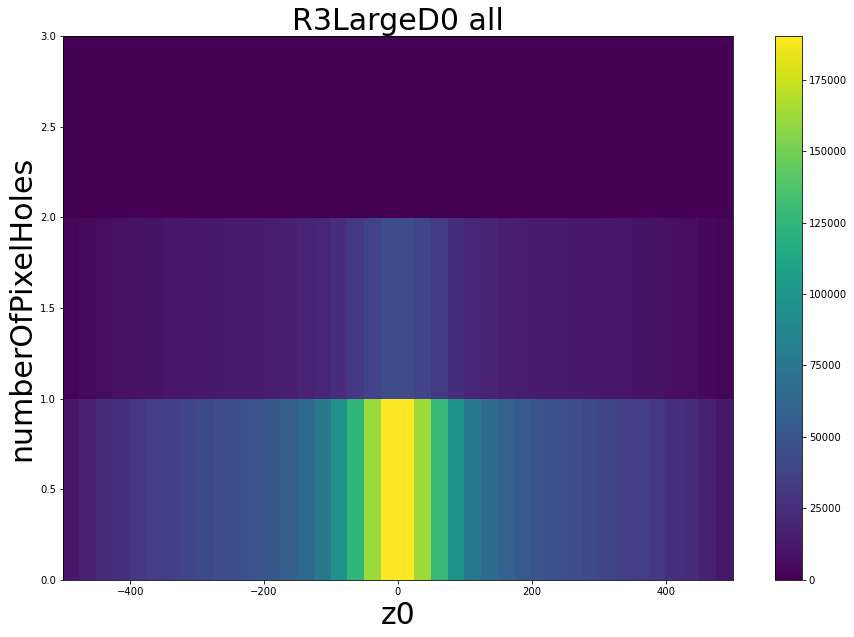

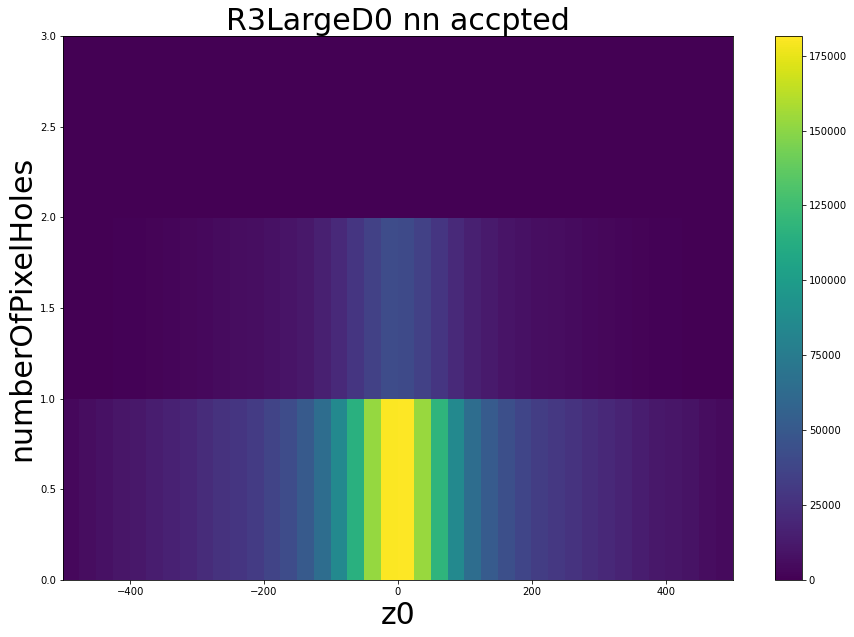

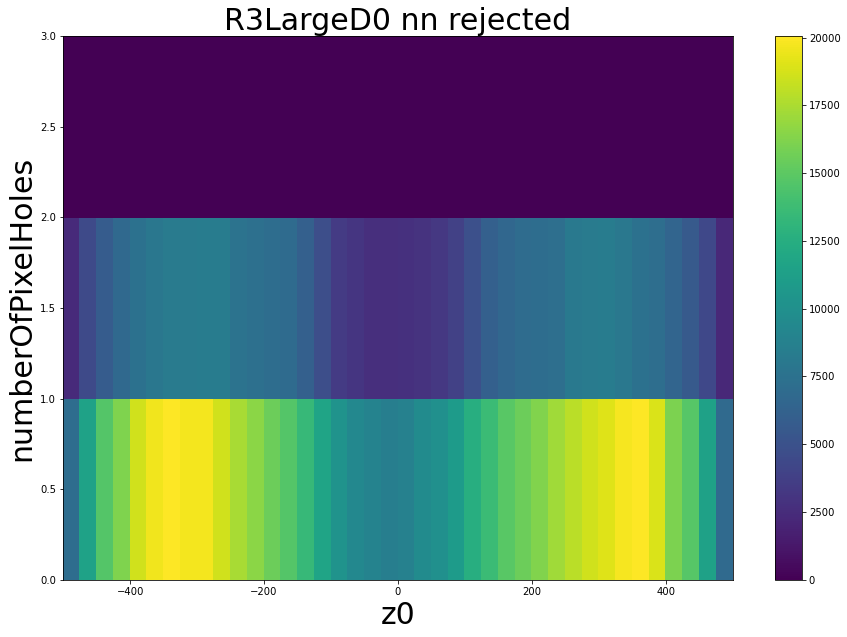

In [18]:
bins = [40, np.arange(0,4)]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'z0', 'numberOfPixelHoles', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'z0', 'numberOfPixelHoles', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'z0', 'numberOfPixelHoles',  -1, bins, 'R3LargeD0 nn rejected', norm=norm)

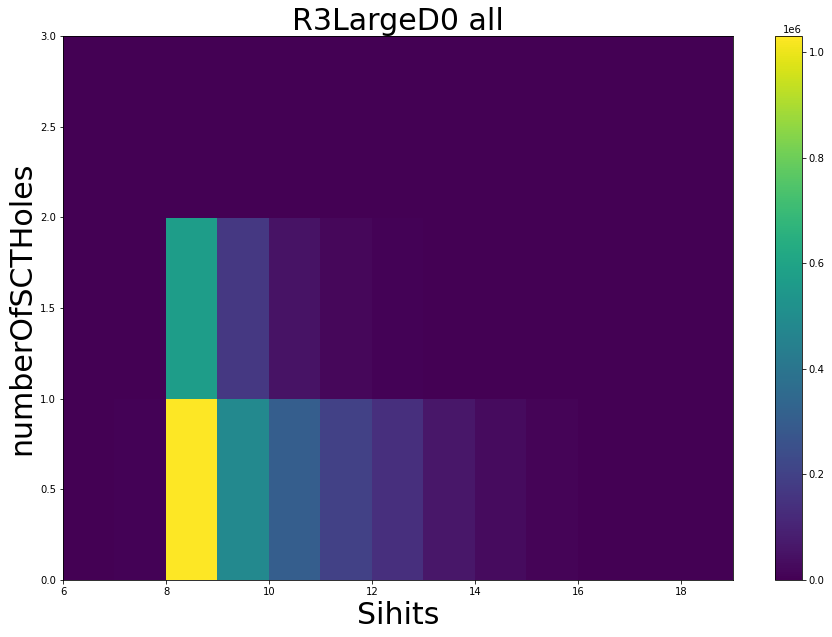

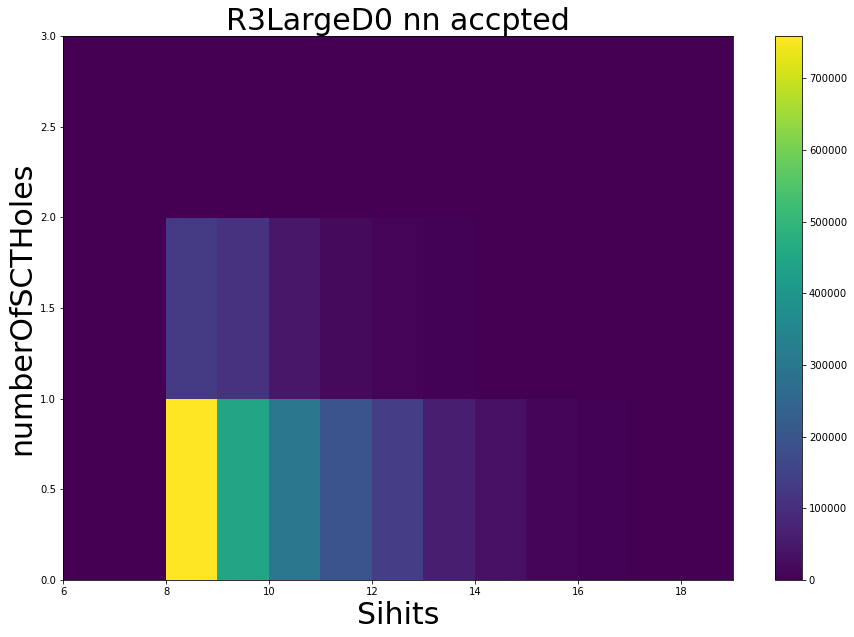

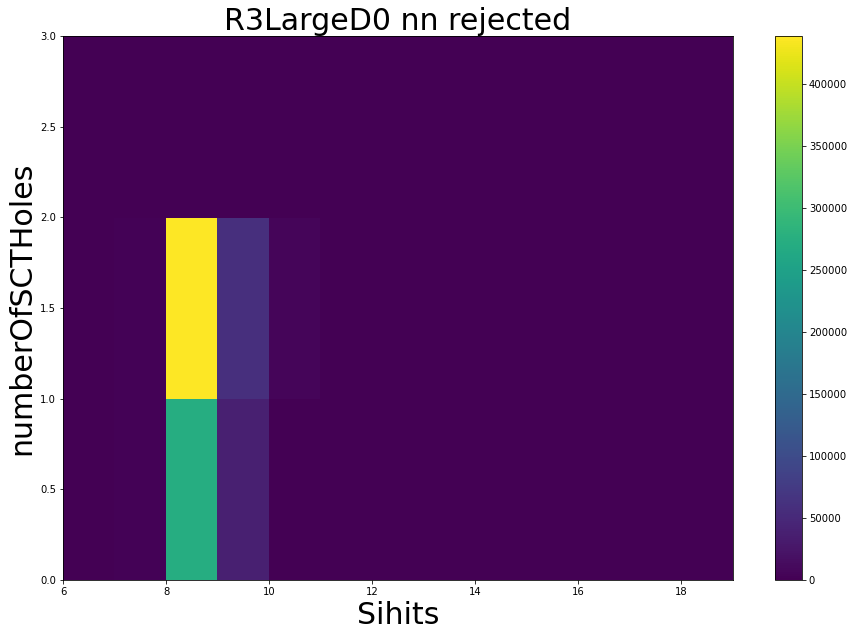

In [19]:
bins = [np.arange(6,20), np.arange(0,4)]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'Sihits', 'numberOfSCTHoles', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'Sihits', 'numberOfSCTHoles', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'Sihits', 'numberOfSCTHoles',  -1, bins, 'R3LargeD0 nn rejected', norm=norm)

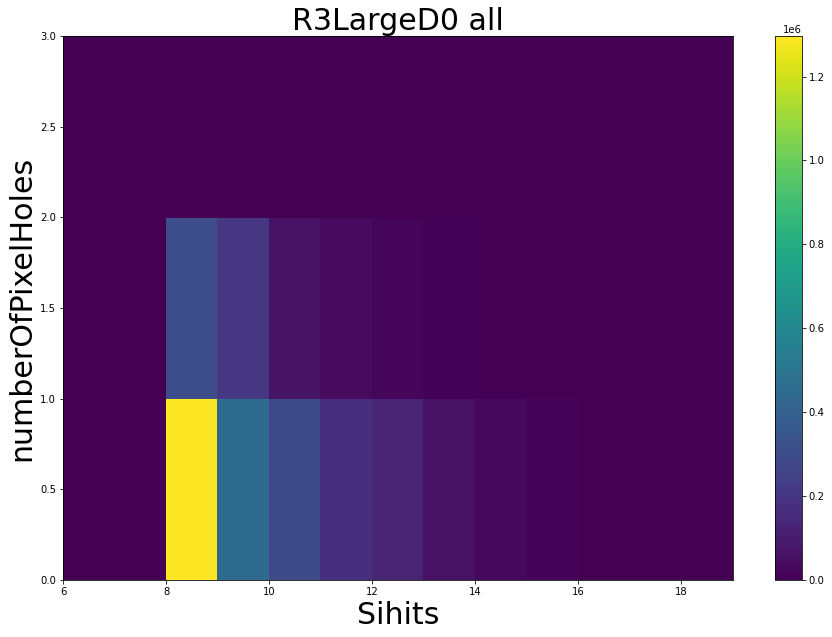

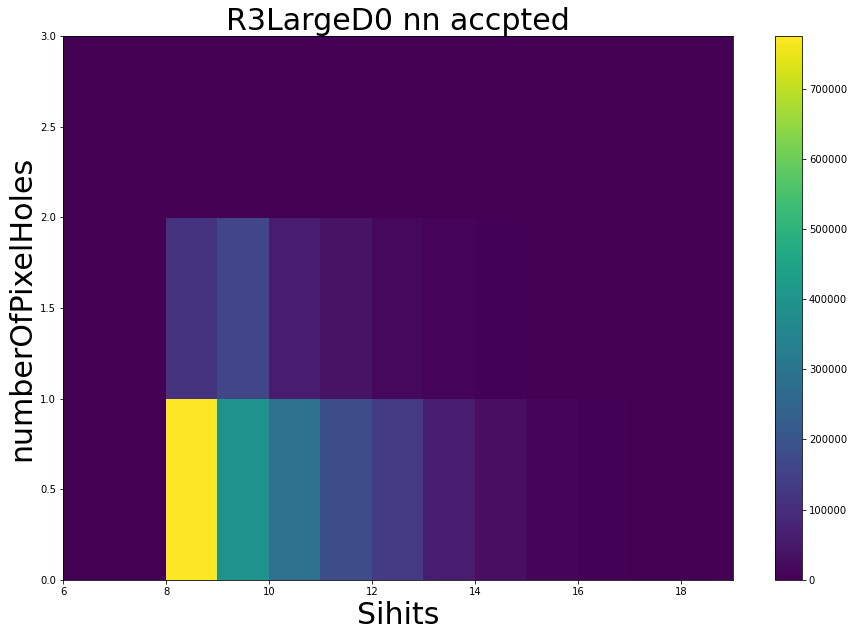

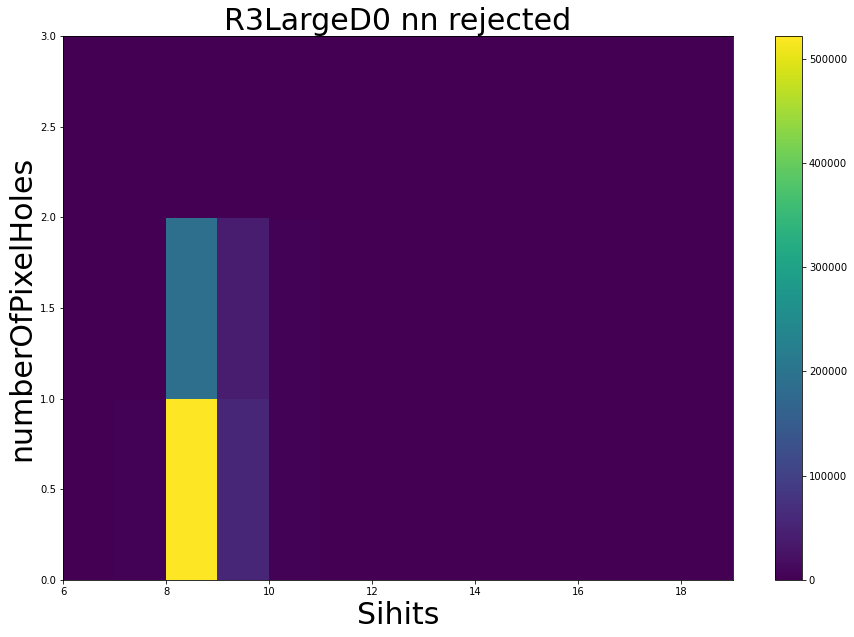

In [20]:
bins = [np.arange(6,20), np.arange(0,4)]
norm=matplotlib.colors.LogNorm()
norm=None
plot2d(df, 'Sihits', 'numberOfPixelHoles', -1, bins, 'R3LargeD0 all', norm=norm)
plot2d(df.query('predictions >  0.1'), 'Sihits', 'numberOfPixelHoles', -1, bins, 'R3LargeD0 nn accpted',   norm=norm)
plot2d(df.query('predictions <= 0.1'), 'Sihits', 'numberOfPixelHoles',  -1, bins, 'R3LargeD0 nn rejected', norm=norm)